## Motivation

In this notebook, we exame the idea declared in section 1.5.5 on Boston housing data, a regression task.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.losses import MSE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from utils import get_gradient_loss_fn

tf.random.set_seed(42)

2024-03-24 10:03:04.779424: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## The Boston Housing Data

We have downloaded the dataset from [Kaggle](https://www.kaggle.com/code/prasadperera/the-boston-housing-dataset) and move it into the `data` folder. We are to follow the strategy of data preprocessing in Kaggle.

In [2]:
column_names = [
    'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV',
]
data = pd.read_csv('data/housing.csv', header=None, delimiter=r"\s+", names=column_names)
data.head(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [3]:
# Let's scale the columns before plotting them against MEDV
min_max_scaler = MinMaxScaler()
column_sels = ['LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX', 'DIS', 'AGE']
x = data.loc[:,column_sels]
y = data['MEDV']
x = pd.DataFrame(data=min_max_scaler.fit_transform(x), columns=column_sels)

In [4]:
y =  np.log1p(y)
for col in x.columns:
    if np.abs(x[col].skew()) > 0.3:
        x[col] = np.log1p(x[col])

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x.values.astype('float32'), y.values.astype('float32'))

## Train a Model with Gradient Loss

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, 'relu'),
    tf.keras.layers.Dense(128, 'relu'),
    tf.keras.layers.Dense(1),
])

gradient_loss_fn = get_gradient_loss_fn(
    lambda inputs: MSE(inputs[1], tf.squeeze(model(inputs[0])))
)

In [7]:
optimizer = tf.optimizers.Adam()

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        _, loss = gradient_loss_fn((x, y))
        loss = tf.reduce_mean(loss)
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))
    return loss

In [8]:
def evaluate(model):
    return MSE(y_test, tf.squeeze(model(x_test)))

In [9]:
ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
ds = ds.batch(100)

In [10]:
for epoch in range(1000):
    for x, y in ds:
        loss = train_step(x, y)
    if epoch % 100 == 0:
        print(epoch, loss.numpy(), evaluate(model).numpy())
print(epoch, loss.numpy(), evaluate(model).numpy())

0 0.0054946286 7.3847294
100 2.1228403e-05 0.03203774
200 1.5560716e-05 0.030497057
300 1.490065e-05 0.030074602
400 1.4214913e-05 0.029285548
500 1.3777495e-05 0.02862252
600 1.3058518e-05 0.027926851
700 1.2866838e-05 0.027347542
800 1.252847e-05 0.02650442
900 1.2211579e-05 0.025941148
999 1.1710437e-05 0.025570998


In [11]:
evaluate(model)

<tf.Tensor: shape=(), dtype=float32, numpy=0.025570998>

## Baseline Model with Usual Loss

In [12]:
baseline_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, 'relu'),
    tf.keras.layers.Dense(128, 'relu'),
    tf.keras.layers.Dense(1)
])

In [13]:
baseline_model.compile(optimizer='adam', loss='mse')

In [14]:
baseline_model.fit(
    x_train, y_train,
    epochs=1000,
    validation_data=(x_test, y_test),
    verbose=2,
)

Epoch 1/1000
12/12 - 0s - loss: 7.4469 - val_loss: 4.3217 - 464ms/epoch - 39ms/step
Epoch 2/1000
12/12 - 0s - loss: 2.6651 - val_loss: 0.8785 - 24ms/epoch - 2ms/step
Epoch 3/1000
12/12 - 0s - loss: 0.8382 - val_loss: 0.9777 - 29ms/epoch - 2ms/step
Epoch 4/1000
12/12 - 0s - loss: 0.6852 - val_loss: 0.4444 - 29ms/epoch - 2ms/step
Epoch 5/1000
12/12 - 0s - loss: 0.3987 - val_loss: 0.2767 - 25ms/epoch - 2ms/step
Epoch 6/1000
12/12 - 0s - loss: 0.2439 - val_loss: 0.1808 - 29ms/epoch - 2ms/step
Epoch 7/1000
12/12 - 0s - loss: 0.1615 - val_loss: 0.1261 - 28ms/epoch - 2ms/step
Epoch 8/1000
12/12 - 0s - loss: 0.1238 - val_loss: 0.1118 - 37ms/epoch - 3ms/step
Epoch 9/1000
12/12 - 0s - loss: 0.1094 - val_loss: 0.0995 - 28ms/epoch - 2ms/step
Epoch 10/1000
12/12 - 0s - loss: 0.0996 - val_loss: 0.0898 - 32ms/epoch - 3ms/step
Epoch 11/1000
12/12 - 0s - loss: 0.0918 - val_loss: 0.0826 - 25ms/epoch - 2ms/step
Epoch 12/1000
12/12 - 0s - loss: 0.0854 - val_loss: 0.0772 - 24ms/epoch - 2ms/step
Epoch 13/10

In [15]:
evaluate(baseline_model)

<tf.Tensor: shape=(), dtype=float32, numpy=0.031819884>

## Model Robustness

Now, we compare the robustness of the model and the baseline. To do so, we add Gaussian noise to the test data and check the accuracy.

In [22]:
stddevs, model_mses, baseline_mses = [], [], []
for stddev in np.linspace(0, 0.5, 20):
    stddevs.append(stddev)
    noise = tf.random.normal(tf.shape(x_test)) * stddev
    model_mses.append(
        MSE(y_test, tf.squeeze(model(x_test+noise))).numpy()
    )
    baseline_mses.append(
        MSE(y_test, tf.squeeze(baseline_model(x_test+noise))).numpy()
    )

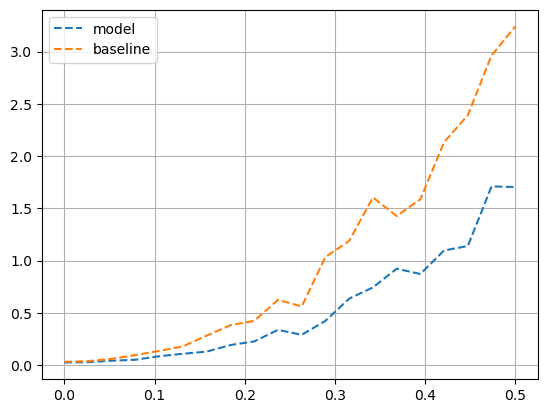

In [23]:
plt.plot(stddevs, model_mses, '--', label='model')
plt.plot(stddevs, baseline_mses, '--', label='baseline')
plt.legend()
plt.grid()
plt.show()

## Conclusion

By simply using the "gradient loss", we obtain a result that approaches the baseline. But the robustness is greatly out-performs the baseline.